# Статистика, DS-поток
## Задание SP.8

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.



**Баллы за задание:**

* Задача 1 &mdash;  100 баллов
* Задача 2 &mdash;  120 баллов
* Задача 3 &mdash;  80 баллов

**Важность задач:**

* *высокая:* задачи 1-3.

<font color="red">**Напоминание**. В задачах могут быть "скрытые" критерии, то есть "заказчик" хочет что-то, что явно не указал в условии. Если вы внимательно следите за удобством восприятия информации в вашем решении, учитываете советы по оформлению и отрабатываете замечания проверяющих, вам не составит труда выполнить эти критерии.</font>

In [ ]:
# Bot check

# HW_ID: ds_sp8
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.nonparametric.kernel_regression import KernelReg

_____
### Задача 5 из SP.7.

Рассмотрим задачу регрессии. Мы уже научились оценивать зависимость $y(x)$, но это только точечная оценка для каждого конкретного $x$. На практике бывает необходимо строить доверительные интервалы, которые в совокупности образуют доверительные ленты. Поскольку мы ничего не знаем про распределение ошибок, будем строить доверительную ленту по методу бутстрепа.

1. Сгенерируем достаточно большое число бутстрепных выборок.

2. Обучим модели и получим значения $\widehat{y}(x)$, для всех значений $x$ по сетке значений.

3. По предсказаным значениям оценим верхнюю и нижнюю границы ленты с помощью методов построения бутстрепных доверительных интервалов.

Напишите функцию, которая реализует данный метод

In [146]:
def ni(X, alpha=0.95):
    """Нормальный интервал"""
    n, B = len(X), len(X)  # B=n
    theta_hat = np.mean(X)
    bootstrap_samples = np.take(np.stack([X]*B), sps.randint.rvs(0, n, size=(B,n)))
    Ts = np.var(bootstrap_samples, axis=1)
    v_boot = np.var(Ts)
    z = sps.norm.ppf((1+alpha)/2)
    return theta_hat - z*np.sqrt(v_boot), theta_hat + z*np.sqrt(v_boot)

def bootstrap_confidence_interval(X, Y, Model, X_grid=None, bootstrap_count=None, alpha=0.95, model_args={}):
    '''
    Построение предсказательной ленты для модели регрессии.
    X,Y - выборка, Model - класс модели, X_grid - сетка для доверительной ленты, alpha - уровень доверия,
    bootstrap_count - количество бутстрепных выборок, model_args - параметры модели.
    '''
    X, Y, X_grid = X.to_numpy(), Y.to_numpy(), X_grid.reshape(-1, 1)
    n = len(Y)
    if bootstrap_count is None:
        bootstrap_count = len(X_grid)
    predictions = []
    for _ in tqdm(np.arange(bootstrap_count)):
        bootstrap_model = Model(**model_args)
        indices = sps.randint.rvs(0, n, size=n)
        bootstrap_model.fit(np.take(X, indices).reshape(-1, 1), np.take(Y, indices).reshape(-1, 1))
        predictions.append(bootstrap_model.predict(X_grid))
    ribbon = np.array([ni(pred, alpha) for pred in predictions])  # готовый метод из задачи 1
    return ribbon[:,0], ribbon[:,1]  # lower, upper

def draw(X_test, y_test, X_grid, lb, ub):
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test, y_test, color='blue', label='Выборка (test)')
    plt.fill_between(X_grid, lb, ub, color='green', alpha=0.4, label='Нормальный интервал')
    # plt.xlim(-7, 7)
    # plt.ylim(-0.01, 0.3)
    plt.xlabel('X (age)')
    plt.ylabel('Y (logwage)')
    plt.title('Доверительная лента')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

Рассмотрим датасет cps71 из семинара

In [147]:
data = pd.read_csv('cps71.csv', index_col=0)
X, Y = data['age'], data['logwage']
data.head(3)

,logwage,age
1,11.1563,21
2,12.8131,22
3,13.0960,22


Разделим нашу выборку на обучающую и тестовую

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_grid = np.linspace(X_test.min(), X_test.max(), 5)

Постройте доверительные ленты для моделей линейной регрессии, ядерной регрессии и KNN-регрессии.
Изобразите на графике также предсказания каждой модели и обучающую выборку.

*Примечание: для классов из statmodels сигнатура класса может не совпадать со стандартной, поэтому сделайте для этих классов, класс-обертку, который в себе просто будет вызывать нужные методы.*

In [149]:
class KernelRegression():  # обертка
    def __init__(self, *args, **kwargs):
        self.args, self.kwargs = args, kwargs
    def fit(self, X, Y):
        self.reg = KernelReg(Y, X, *self.args, var_type='o', **self.kwargs)
        return self
    def predict(self, X):
        return self.reg.fit()[0]

  0%|          | 0/5 [00:00<?, ?it/s]

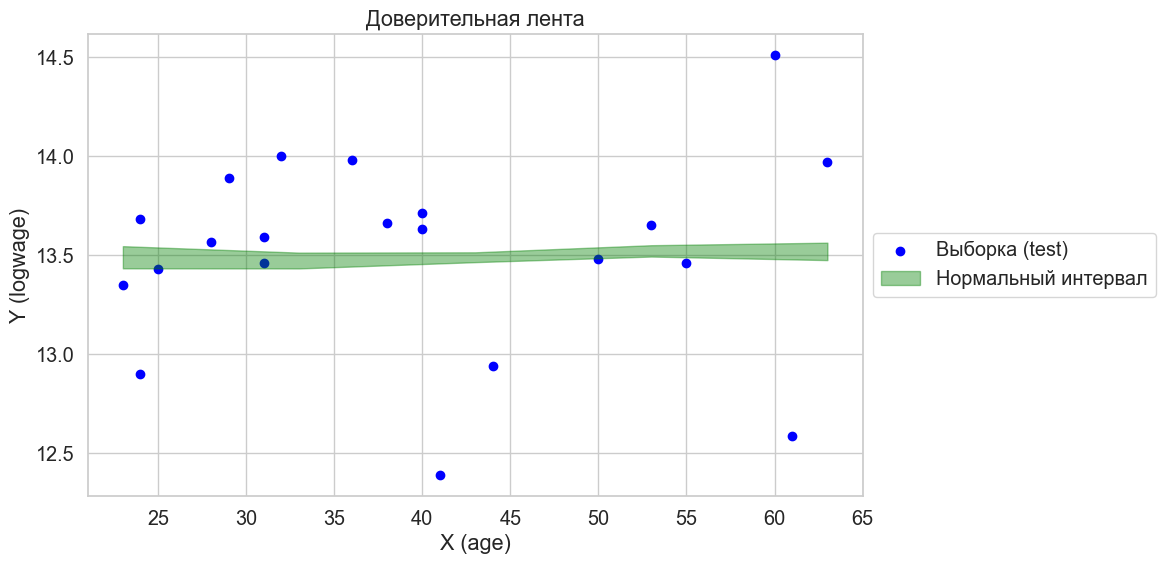

In [151]:
lb,ub = bootstrap_confidence_interval(X_train, y_train, KernelRegression, X_grid, alpha=0.95, model_args={})
draw(X_test, y_test, X_grid, lb, ub)

  0%|          | 0/5 [00:00<?, ?it/s]

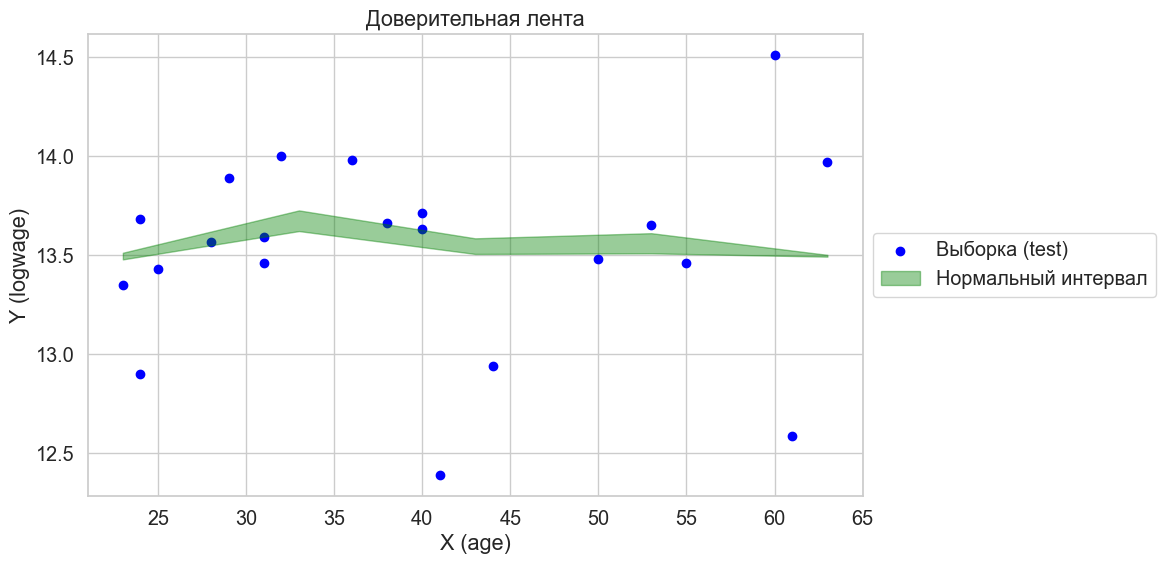

In [153]:
lb,ub = bootstrap_confidence_interval(X_train, y_train, LinearRegression, X_grid, alpha=0.95, model_args={})
draw(X_test, y_test, X_grid, lb, ub)

  0%|          | 0/5 [00:00<?, ?it/s]

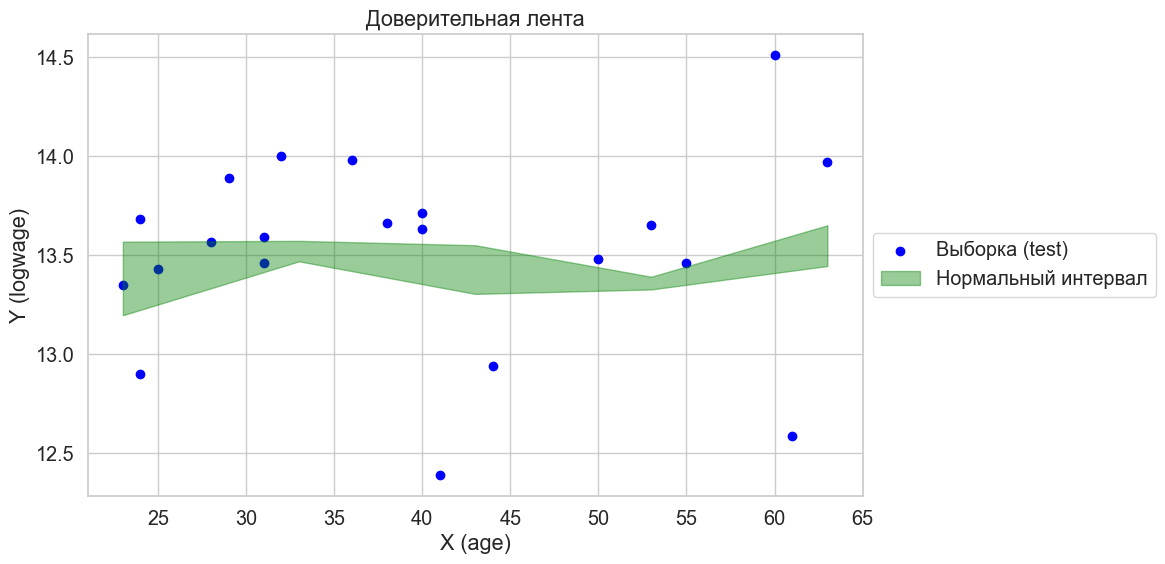

In [154]:
lb,ub = bootstrap_confidence_interval(X_train, y_train, KNeighborsRegressor, X_grid, alpha=0.95, model_args={})
draw(X_test, y_test, X_grid, lb, ub)

Сделайте выводы

***Вывод:** в задаче удалось ближе познакомиться с таким инструментом, как доверительные ленты. Получилось, что доверительная лента, построенная с помощью нормального бутстрепного интервала, дает чрезмерно оптимистичные предсказания. Это наглядно демонстрирует ограничения бутстрепных подходов*

_____
### Задача 1.

В одной известной компании поставлена задача построения нейросети для распознавания котиков и песиков. Для построения такого бинарного классификатора собрана коллекция изображений со сбалансированными классами.

Прошел месяц работы аналитиков и ML-разработчиков, и, наконец-то, нейросеть обучена и готова к использованию. Но руководство хочет убедится, что месяц работы прошел не зря, и построенная нейросеть действительно дает результат.
Как известно, случайный классификатор, выдающий для каждого объекта случайный класс, угадывает ответ правильно с вероятностью $1/2$. И руководству будет достаточно, если модель будет работать лучше. Однако, как их убедить в том, что та же точность 60% действительно отличается от 50%, а не вызвана чистой случайностью? На помощь приходит проверка статистических гипотез &mdash; вы можете проверить статистическую значимость отклонения от базовой точности 50%, и предъявить ее в качестве доказательства.

Сформулируем задачу на математическом языке. Пусть $X_1, ..., X_n \sim Bern(p)$ &mdash; результаты работы модели на тестовой выборке, где $X_i = 1$, если для $i$-го объекта модель правильно определила класс, а $p$ &mdash; неизвестная вероятность такого события.
Мы хотим проверить гипотезу $\mathsf{H}_0\colon p=1/2$ против альтернативы $\mathsf{H}_1\colon p>1/2$. Нулевая гипотеза означает, что построенный классификатор выдает рандомный ответ, а первая &mdash; что чаще все же выдает верный ответ.

На семинаре получено, что $S = \left\{T(x) \geqslant c_\alpha\right\}$, где $T(X) = \sum\limits_{i=1}^n X_i$, является равномерно наиболее мощным критерием для проверки этих гипотез.
Чему при этом равно $c_\alpha$? Учтите, что распределение дискретное, и строгий/нестрогий знак имеет значение.

***Ответ:** сумма бернуллиевских величин $T(X) \sim Bin(n,p) $. Ищем такое $c_{\alpha}$, что $P(T(X) \geq c_{\alpha} \mid H_0) = \alpha$, что эквивалентно $P(T(X) < c_{\alpha} \mid p=1/2) = 1 - \alpha$*.  
*Тогда $c_{\alpha} = sps.binom.ppf(1-\alpha, n=n, p=0.5)$* 

Проверьте, что критерий работает.
Возьмите несколько значений $n$ и реализаций статистики $T(X)$.
В каждом случае найдите значение $c_\alpha$, а также выведите результат процедуры проверки гипотез 0/1 &mdash; отвергается ли $\mathsf{H}_0$ (выводите 1, если отвергается).
Оформите это в виде таблицы, можно через `pandas.DataFrame`.

*Замечание:* Пользуйтесь функциями из `scipy.stats`.

In [123]:
n = np.arange(1, 1000+2)
sample = sps.bernoulli.rvs(p=1/2, size=len(n))
table = pd.DataFrame({'n':n, 'T(X)':np.cumsum(sample), 'c_a':sps.binom.ppf(1-0.05, n=n, p=0.5)})
table['Итог'] = (table['T(X)'] >= table['c_a']).astype(int)  # проверка критерия S
table[table.n.isin([10,50,100,500,1000])]

,n,T(X),c_a,Итог
9,10,5,8.0,0
49,50,31,31.0,1
99,100,60,58.0,1
499,500,266,268.0,0
999,1000,517,526.0,0


*Критерий работает*

Теперь для некоторых $n$ постройте графики функции мощности критерия при $1/2 < p < 1$ и уровне значимости 0.05. Сравните их.

$\beta_S = P(T(x) \geq c_{\alpha} \mid p > 1/2) = 1 - F_{T(x)}(c_{\alpha})$,  где $T(x) \sim Bin(n,p), p > 1/2, c_{\alpha}$ из таблицы выше  

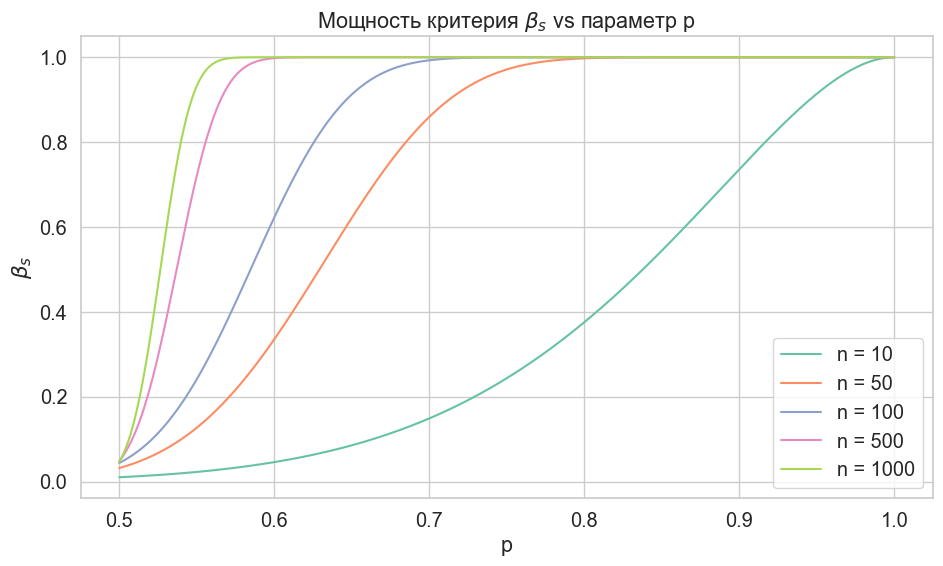

In [111]:
p = np.linspace(1/2, 1, 1000)
plt.figure(figsize=(11,6))
for n in [10,50,100,500,1000]:
    b_s = sps.binom.sf(table[table.n==n]['c_a'], n=n, p=p)
    plt.plot(p, b_s, label=f'n = {n}')
plt.legend()
plt.title('Мощность критерия $\\beta_s$ vs параметр p')
plt.xlabel('p')
plt.ylabel('$\\beta_s$')
plt.show()

***Вывод:** в задаче удалось ближе познакомиться с РНМК. Например, по таблице можно заметить, что $c_a$ растет с ростом n, что логично, ведь растет и статистика (сумма величин). При этом, по 2му графику видно, что с ростом размера выборки построить мощный критерий становится проще (кривые приближаются к 1 даже при p близких к 1/2)*

_____
### Задача 2.

На практике часто рассматривают асимптотические критерии, например, критерий Вальда. Такие критерии контролируют вероятность ошибки I рода на уровне $\alpha$ только в пределе, однако для небольших выборок она может сильно отличаться от $\alpha$, причем не редко в большую сторону. Поэтому для таких критериев возникает необходимость в вычислении значения вероятности ошибки I рода при конечной выборке.

Зачастую посчитать точное значение вероятности ошибки I рода довольно сложно, поэтому вместо него вычисляют оценку с помощью семплирования по методу Монте-Карло.

Пусть гипотеза $\mathsf{H}_0$ простая, то есть $\mathsf{H}_0\colon \mathsf{P} = \mathsf{P}_0$. Для ее проверки по конечной выборке $X_1, ..., X_n$ используется критерий $S$. **Опишите схему оценки вероятности ошибки I рода** критерия $S$ методом Монте-Карло.

***Ответ:***  
*Из распределения $\mathsf{P}_0$ сгенерируем $m$ выборок размера $n$. Для каждой выборки оценим индикатор $I(X^j \in S), j=1,...,m$. Пусть $\displaystyle\sum_{j=1}^{m} I(X^j \in S) = t$*  
*Вероятность ошибки I рода $P(I_s) = \displaystyle\sup_{\mathsf{P} \in \mathscr{P}_0} P(X \in S) = P(X \in S \mid \mathsf{P} = \mathsf{P}_0) \approx \frac{t}{m}$. Это и будет оценкой вер-ти ошибки I рода по методу М.-К.*  

Если гипотеза $\mathsf{H}_0$ сложная, то есть $\mathsf{H}_0\colon \mathsf{P} \in \mathscr{P}_0$, то можно повторить такую процедуру несколько раз для разных $\mathsf{P} \in \mathscr{P}_0$.

Рассмотрим альтернативную гипотезу $\mathsf{H}_1\colon \mathsf{P} \in \mathscr{P}_1$. **Опишите схему оценки мощности** критерия $S$ методом Монте-Карло.

***Ответ:***  
*1) выберем несколько $\mathsf{P} \in \mathscr{P}_1$ и для каждого распределения проведем шаги 2-3*  
*2) из $\mathsf{P}$ сгенерируем $m$ выборок размера $n$. Для каждой выборки оценим индикатор $I(X^j \in S), j=1,...,m$. Пусть $\displaystyle\sum_{j=1}^{m} I(X^j \in S) = t$*  
*3) мощность $\beta_S = 1 - P(II_S) = P(X \in S \mid \mathsf{P} \in \mathscr{P}_1) \approx \frac{t}{m}$. Это будет оценкой мощности по методу М.-К. для одного конкретного распределения из семейства $\mathscr{P}_1$*  
*4) в качестве итоговой оценки мощности возьмем максимум из полученных ответов*  

Пусть $X_1, ..., X_n$ &mdash; выборка из пуассоновского распределения с параметром $\theta$. Рассмотрим гипотезы $\mathsf{H}_0\colon \theta = 1\ \ vs.\ \ \mathsf{H}_1\colon \theta \not= 1$ и критерий Вальда для их проверки.

**1.** **Оцените вероятности ошибки I рода** критерия для размеров выборки $1 \leqslant n \leqslant 50$ и визуализируйте полученную зависимость.

*Вспомним двусторонний критерий Вальда уровня значимости $\alpha$: $S = \{\mid \sqrt{n} \frac{\hat{\theta} - \theta_0}{\hat{\sigma}} \mid \geq z_{1-\frac{\alpha}{2}}\}$, то есть $\{\mid \sqrt{n} \frac{\overline{X} - 1}{\sqrt{\overline{X}}} \mid \geq z_{1-\frac{\alpha}{2}}\}$*  

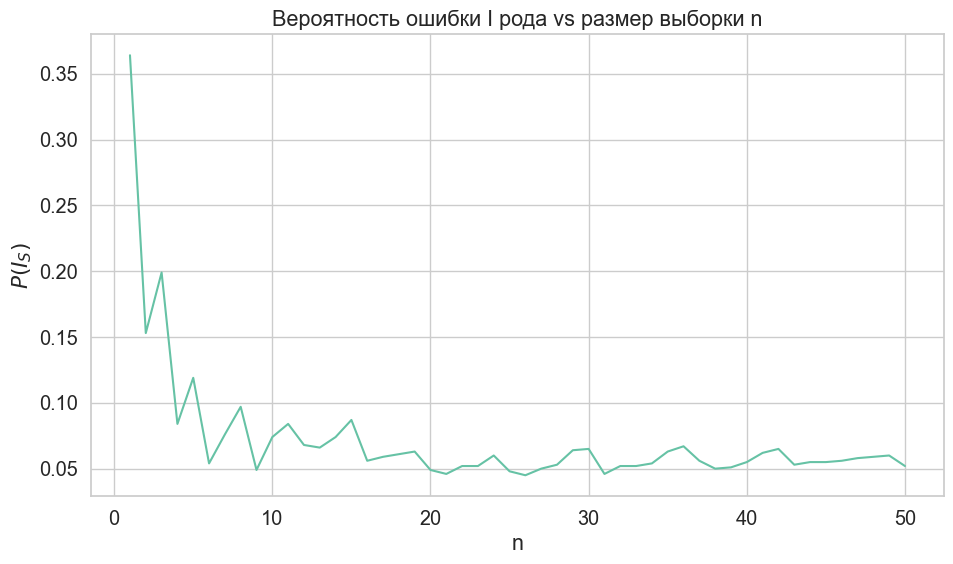

In [203]:
def S(X, a=0.05):  
    """Двусторонний критерий Вальда уровня значимости a"""
    cumsum, n = X.cumsum(axis=-1), np.arange(1, X.shape[-1]+1)
    X_bar = cumsum / n + 1e-7  # добавляю 1e-7 чтобы избежать деления на 0
    return np.abs((X_bar-1) * np.sqrt(n/X_bar)) >= sps.norm.ppf(1 - a/2)

m = 1_000
samples = sps.poisson.rvs(mu=1, size=(m,50))
P_I = S(samples).sum(axis=0) / m

plt.figure(figsize=(11,6))
plt.plot(np.arange(1,len(P_I)+1), P_I)
plt.title('Вероятность ошибки I рода vs размер выборки n')
plt.xlabel('n')
plt.ylabel('$P(I_S)$')
plt.show()

***Вывод:** с ростом размера выборки n ошибка I рода уменьшается, а метод Монте-Карло позволяет довольно хорошо ее оценить*

**2.** Для значений $n \in \{5, 15, 50\}$ **оцените функцию мощности критерия** для значений $\theta \in (0, 5)$ по сетке с шагом 0.01 по методу Монте-Карло. Визуализируйте полученные зависимости.

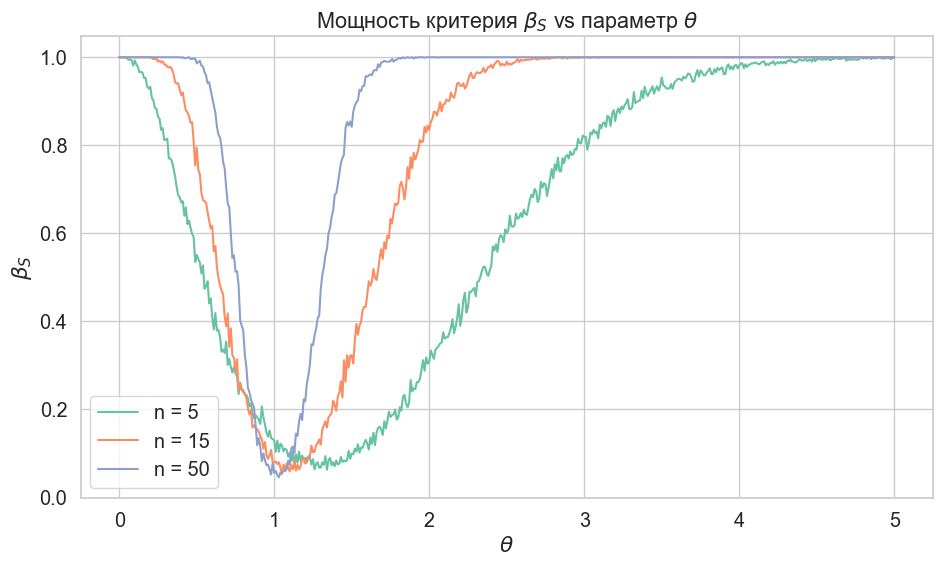

In [211]:
def S(X, a=0.05):  
    """Двусторонний критерий Вальда уровня значимости a, более удобная реализация для этого пункта"""
    X_bar, n = X.mean(axis=-1)+1e-7, X.shape[-1]   # добавляю 1e-7 чтобы избежать деления на 0
    return np.abs((X_bar-1) * np.sqrt(n/X_bar)) >= sps.norm.ppf(1 - a/2)

m = 1_000
thetas = np.arange(0,5.01,0.01)
plt.figure(figsize=(11,6))
for n in [5,15,50]:
    beta_S = []
    for theta in thetas:
        samples = sps.poisson.rvs(mu=theta, size=(m,n))
        beta_S.append(S(samples).sum(axis=0) / m)
    plt.plot(thetas, beta_S, label=f'n = {n}')

plt.legend()
plt.title('Мощность критерия $\\beta_S$ vs параметр $\\theta$')
plt.xlabel('$\\theta$')
plt.ylabel('$\\beta_S$')
plt.show()

***Вывод:** с ростом выборки n становится проще построить мощный критерий (график приближается к идеальному значению 1 по своим краям). Зависимость от параметра выражается в виде пика, обращенного вниз и сдвигающегося влево с ростом n*

**3.** Пусть $n=50$. **Сравните мощности критериев**, соответствующих двусторонней, левосторонней и правосторонней альтернативам.

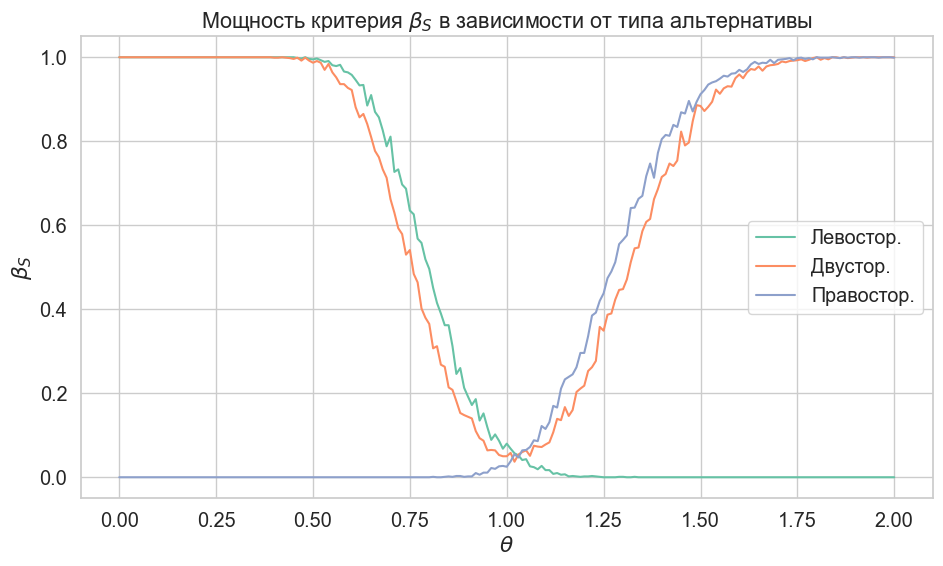

In [218]:
def S(X, mode, a=0.05):  
    """Левосторонний критерий Вальда уровня значимости a"""
    X_bar, n = X.mean(axis=-1)+1e-7, X.shape[-1]   # добавляю 1e-7 чтобы избежать деления на 0
    if mode=='Левостор.':
        return (X_bar-1) * np.sqrt(n/X_bar) <= sps.norm.ppf(a)
    elif mode=='Двустор.':
        return np.abs((X_bar-1) * np.sqrt(n/X_bar)) >= sps.norm.ppf(1 - a/2)
    elif mode=='Правостор.':
        return (X_bar-1) * np.sqrt(n/X_bar) >= sps.norm.ppf(1-a)

m = 1_000
thetas = np.arange(0,2.01,0.01)
plt.figure(figsize=(11,6))
for mode, rng in zip(['Левостор.','Двустор.','Правостор.'],[0,0,0]):
    beta_S = []
    for theta in thetas:
        samples = sps.poisson.rvs(mu=theta, size=(m,50))
        beta_S.append(S(samples, mode=mode).sum(axis=0) / m)
    plt.plot(thetas, beta_S, label=mode)

plt.legend()
plt.title('Мощность критерия $\\beta_S$ в зависимости от типа альтернативы')
plt.xlabel('$\\theta$')
plt.ylabel('$\\beta_S$')
plt.show()

***Вывод:** получился график, как на лекции. Это говорит о высокой полезности метода М.-К. По графику видно, почему для разных альтернатив стоит выбирать разные критерии (ведь мощность получится разной). Кроме того видно, что двусторонний критерий уступает по мощности лево- и правостороннему на соответствующих участках, но при этом одинаково "силен" и там, и там, в отличие от односторонних критериев, обладающих нулевой мощностью на неудачных участках*

**Вопрос на подумать.** Сколько семплирований в методе Монте-Карло нужно сделать, чтобы оценить вероятности ошибки I рода с точностью до 0.001? Иначе говоря, значения (0.049, 0.051) можно принять за 0.05.

*Порядок погрешности метода М.-К. известен и составляет $\frac{1}{\sqrt{m}}$. Значит, чтобы гарантировать точность до 0.001, нужно сделать порядка $m \sim 10^6$ семплироаний*

_____
### Задача 3.

Пусть $X_1, ..., X_n$ &mdash; выборка из распределения $\Gamma(\theta, \beta)$. Рассмотрим основную гипотезу $\mathsf{H}_0\colon \theta = 2$.

**1.** Пусть $\beta$ неизвестно. Для размеров выборки $n \in \{5, 15, 30, 50, 100\}$ **оцените вероятности ошибки I рода** критерия Вальда для двусторонней альтернативы в зависимости от истинных значений $\beta$. Визуализируйте полученные зависимости.

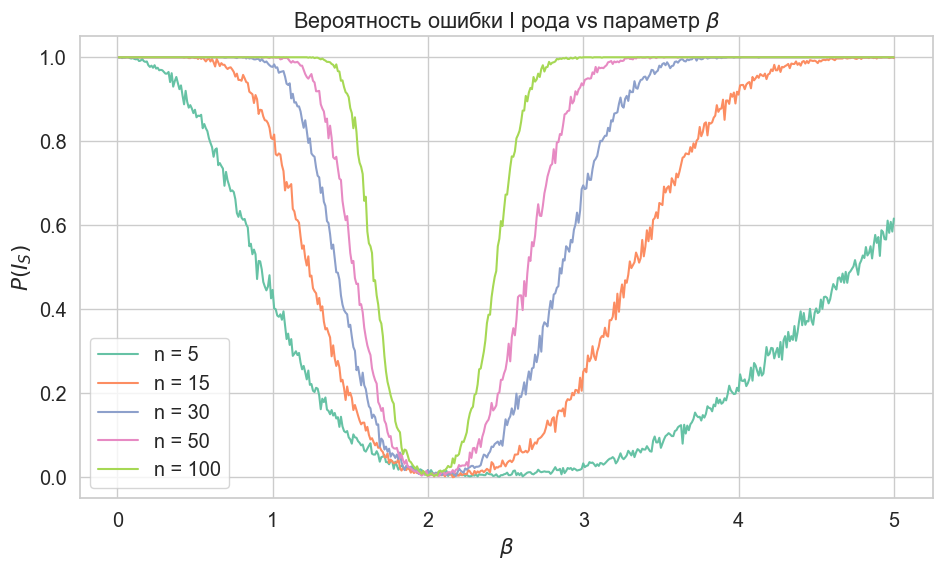

In [8]:
def S(X, a=0.05):  
    """Двусторонний критерий Вальда уровня значимости a, более удобная реализация для этого пункта"""
    X_bar, n = X.mean(axis=-1)+1e-7, X.shape[-1]   # добавляю 1e-7 чтобы избежать деления на 0
    return np.abs((X_bar-1) * np.sqrt(n/X_bar)) >= sps.norm.ppf(1 - a/2)

m = 1_000
betas = np.arange(0.01,5.01,0.01)
plt.figure(figsize=(11,6))
for n in [5,15,30,50,100]:
    P_I = []
    for beta in betas:
        samples = sps.gamma.rvs(a=beta, scale=1/2, size=(m,n))
        P_I.append(S(samples).sum(axis=0) / m)
    plt.plot(betas, P_I, label=f'n = {n}')
plt.legend()
plt.title('Вероятность ошибки I рода vs параметр $\\beta$')
plt.xlabel('$\\beta$')
plt.ylabel('$P(I_S)$')
plt.show()

***Вывод:** когда истинный параметр близок к параметру из гипотезы (в данном случае - к 2), становится сложнее бороться с ошибкой I рода (виден провал на графике вблизи 2). Это логично, потому что различия становятся менее "экстремальными" и сделать надежный вывод становится сложнее*

**2.** Пусть $\beta$ известно. **Сравните по мощности** РНМК и критерий Вальда (*для известной $\beta$*) для левосторонней и правосторонней альтернатив, а также двусторонней альтернативы для критерия Вальда.

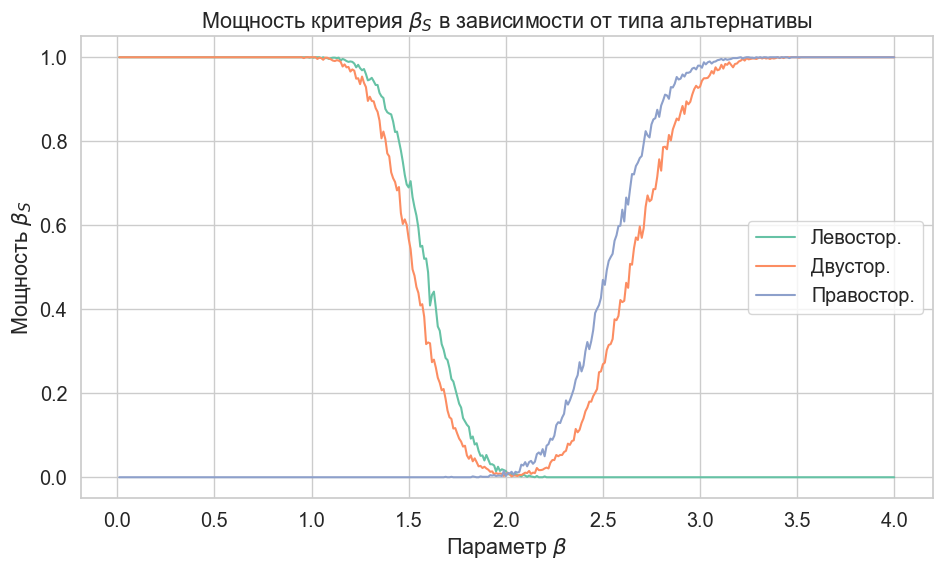

In [10]:
def S(X, mode, a=0.05):  
    """Левосторонний критерий Вальда уровня значимости a"""
    X_bar, n = X.mean(axis=-1)+1e-7, X.shape[-1]   # добавляю 1e-7 чтобы избежать деления на 0
    if mode=='Левостор.':
        return (X_bar-1) * np.sqrt(n/X_bar) <= sps.norm.ppf(a)
    elif mode=='Двустор.':
        return np.abs((X_bar-1) * np.sqrt(n/X_bar)) >= sps.norm.ppf(1 - a/2)
    elif mode=='Правостор.':
        return (X_bar-1) * np.sqrt(n/X_bar) >= sps.norm.ppf(1-a)

m = 1_000
betas = np.arange(0.01,4.01,0.01)
plt.figure(figsize=(11,6))
for mode, rng in zip(['Левостор.','Двустор.','Правостор.'],[0,0,0]):
    beta_S = []
    for beta in betas:
        samples = sps.gamma.rvs(a=beta, scale=1/2, size=(m,50))
        beta_S.append(S(samples, mode=mode).sum(axis=0) / m)
    plt.plot(betas, beta_S, label=mode)

plt.legend()
plt.title('Мощность критерия $\\beta_S$ в зависимости от типа альтернативы')
plt.xlabel('Параметр $\\beta$')
plt.ylabel('Мощность $\\beta_S$')
plt.show()

***Вывод:** наблюдаем очень похожий график зависимости мощности от типа альтернативы, что в очередной раз подчеркивает важность правильного подбора наиболее мощного критерия.*